
## How to Use the Notebooks

To run these notebooks, follow these steps:


### 1. Install **`gdal`** Package
Installing `gdal` via `pip` may fail. Therefore, we recommend using conda to install it:
```bash
conda install gdal -c conda-forge
```

### 2. Install **`polsartools`** Package

Before running the notebooks, you'll need to install the core **`polsartools`** package. 

**Option A:** Install from PyPI `pip` (stable release)

```bash
pip install polsartools
```

**Option B:** Install from conda (stable release)

```bash
conda install polsartools -c bnarayanarao
```


**Option C:**  Install the latest version from GitHub (if you need recent updates or fixes)

```bash
pip install git+https://github.com/Narayana-Rao/polsartools.git#egg=polsartools
```
> **Note:** If you encounter a `"module not found"` error or require newer features, prefer the [GitHub installation](https://github.com/Narayana-Rao/polsartools).

### 3. Verify the Installation

After successfully installing `polsartools`, you can verify it by importing the package:

```bash
import polsartools as pst
```

If this runs without errors, you're ready to explore and run the notebooks.




In [1]:
import polsartools as pst
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np


In [2]:

def read_rst(file):
    ds = gdal.Open(file)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    arr[arr==0] = np.nan
    return arr


def plot_images(*filenames, lower_percentile=2, upper_percentile=98, max_cols=4):
    # Function to compute vmin and vmax based on nanpercentiles
    def compute_vmin_vmax(data):
        data_no_nan = data[np.isfinite(data)]  # Remove NaNs
        vmin = np.percentile(data_no_nan, lower_percentile)
        vmax = np.percentile(data_no_nan, upper_percentile)
        return vmin, vmax
    
    # Number of images to plot
    num_images = len(filenames)

    # Calculate the number of rows and columns
    ncols = min(max_cols, num_images)  # Use max_cols but limit it to num_images
    nrows = np.ceil(num_images / ncols).astype(int)  # Calculate number of rows

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    axes = axes.flatten() 

    for i, filename in enumerate(filenames):
        data = read_rst(filename)  # Load the data from the file
        vmin, vmax = compute_vmin_vmax(data)
        ax = axes[i]
        im = ax.imshow(data, vmin=vmin, vmax=vmax)
        ax.set_title(os.path.basename(filename))
        fig.colorbar(im, ax=ax)

    # Turn off any unused axes
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

#### 1. Extract single look S2 or multilooked T3/C3 matrix elements
ASAR data can be downloaded from [https://uavsar.jpl.nasa.gov/cgi-bin/asar-data.pl](https://uavsar.jpl.nasa.gov/cgi-bin/asar-data.pl)

The sample a dataset used in this tutorial can be downloaded from the following URLs

http://downloaduav.jpl.nasa.gov/Release2s/Rosamd_1702N_A2102_003_210630/V1.3.B/L/ASAR_L_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B.h5

http://downloaduav.jpl.nasa.gov/Release2s/Rosamd_1702N_A2102_003_210630/V1.3.B/S/ASAR_S_JOINT_FP_ID1702N_LINE03_RUN02_300621_LEVEL1_RSLC_V1.3.B.h5

In [3]:
# Provide path to the extracted folder
inFile = r"ASAR_L_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637.h5"
inFile = r"ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637.h5"

#The follwoing function extracts single look S2 or mulit-looked T3/C3 matrix from ISRO's ASAR Full Pol data
pst.isro_asar(inFile,matrix='C3',azlks=22,rglks=10) # for a multi-look factor of 2.16


Considering S12 = S21
 Detected S-band data
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637\C3/C11.bin
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637\C3/C12_real.bin
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637\C3/C12_imag.bin
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637\C3/C13_real.bin
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637\C3/C13_imag.bin
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637\C3/C22.bin
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637\C3/C23_real.bin
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637\C3/C23_imag.bin
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637\C3/C33.bin
Execution time for isro_asar: 12.00 seconds


#### 2. Speckle filtering using polarimetric refined-Lee filter (optional)

In [4]:
"""
The following function generates speckel filtered polarimetric matrices using refined lee polarimetric speckle filter: 
        
input C3/T3/C2/T2 folder path, window_size between 3-31  

"""

C3Folder = r'.\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637\C3'
window_size = 3
pst.rlee(C3Folder,window_size=window_size)

Progress : 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.53 block/s]


Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3\C11.bin
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3\C12_real.bin
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3\C12_imag.bin
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3\C13_real.bin
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3\C13_imag.bin
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3\C22.bin
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3\C23_real.bin
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3\C23_imag.bin
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3\C33.bin
Execution time for rlee: 2.00 seconds


#### 3. Generate a quick look Pauli RGB from C3/T3 matrix (optional)

Pauli RGB image saved as .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3\PauliRGB.png
Execution time for pauliRGB: 0.00 seconds


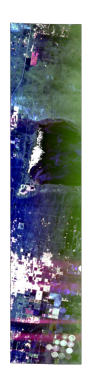

In [5]:
# update the C3 folder based on your folder
C3Folder = r'.\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3'

pst.utils.pauliRGB(C3Folder)

#### 4. Generating Decomposition parameters

#### 4.1. Generate H/A/α Decomposition parameters

Progress : 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.53 block/s]


Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3\H_fp.tif
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3\alpha_fp.tif
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3\anisotropy_fp.tif
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3\e1_norm.tif
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3\e2_norm.tif
Saved file .\ASAR_S_JOINT_FP_ID_1702N_LINE03_RUN02_30062021163637_rlee_3x3\C3\e3_norm.tif
Execution time for halphafp: 3.00 seconds


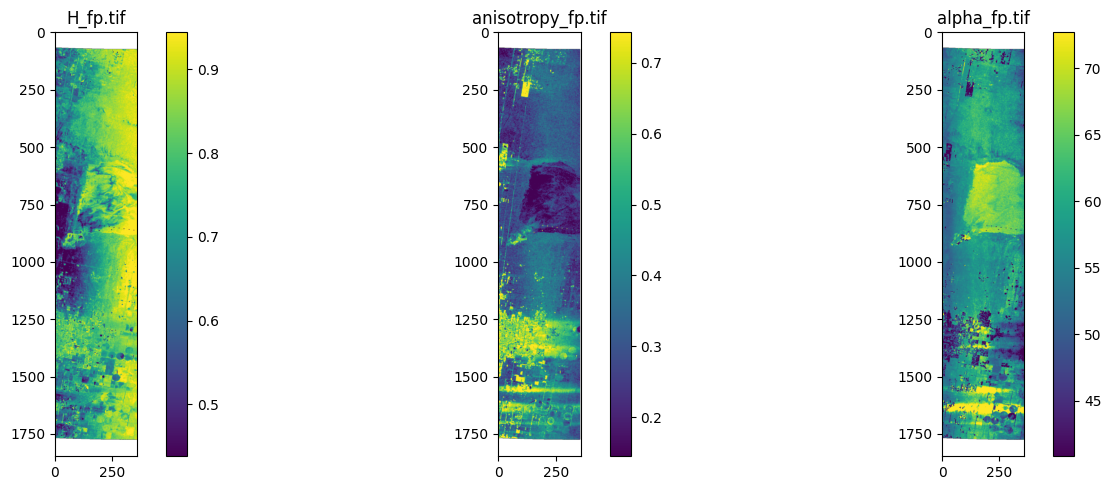

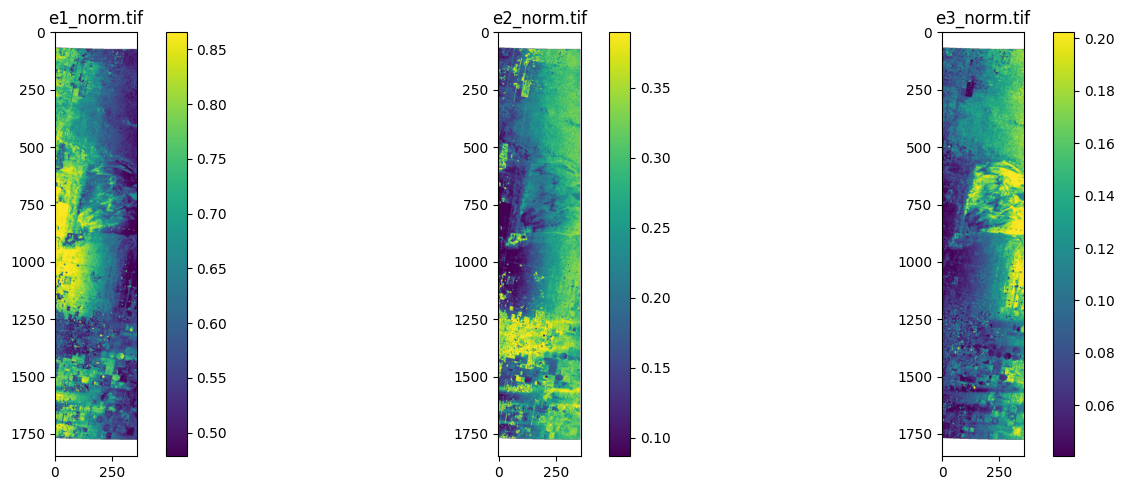

In [6]:

"""
The following function generates H/A/alpha demposition paramters: 
        Alpha, entropy, anisotropy and 
        normalized eigen values e1_norm, e2_norm, e3_norm in geotif format

input C3/T3 folder path, window_size is optional  

"""
# update the C3 folder based on your folder
# C3Folder = '._rlee_3x3\C3'

pst.halphafp(C3Folder,window_size=3) 


### Plotting
plot_images(os.path.join(C3Folder,'H_fp.tif'),
             os.path.join(C3Folder,'anisotropy_fp.tif'),
              os.path.join(C3Folder,'alpha_fp.tif'))

plot_images(os.path.join(C3Folder,'e1_norm.tif'),
             os.path.join(C3Folder,'e2_norm.tif'),
             os.path.join(C3Folder,'e3_norm.tif'))




#### Plot Entropy-Alpha 2D plane

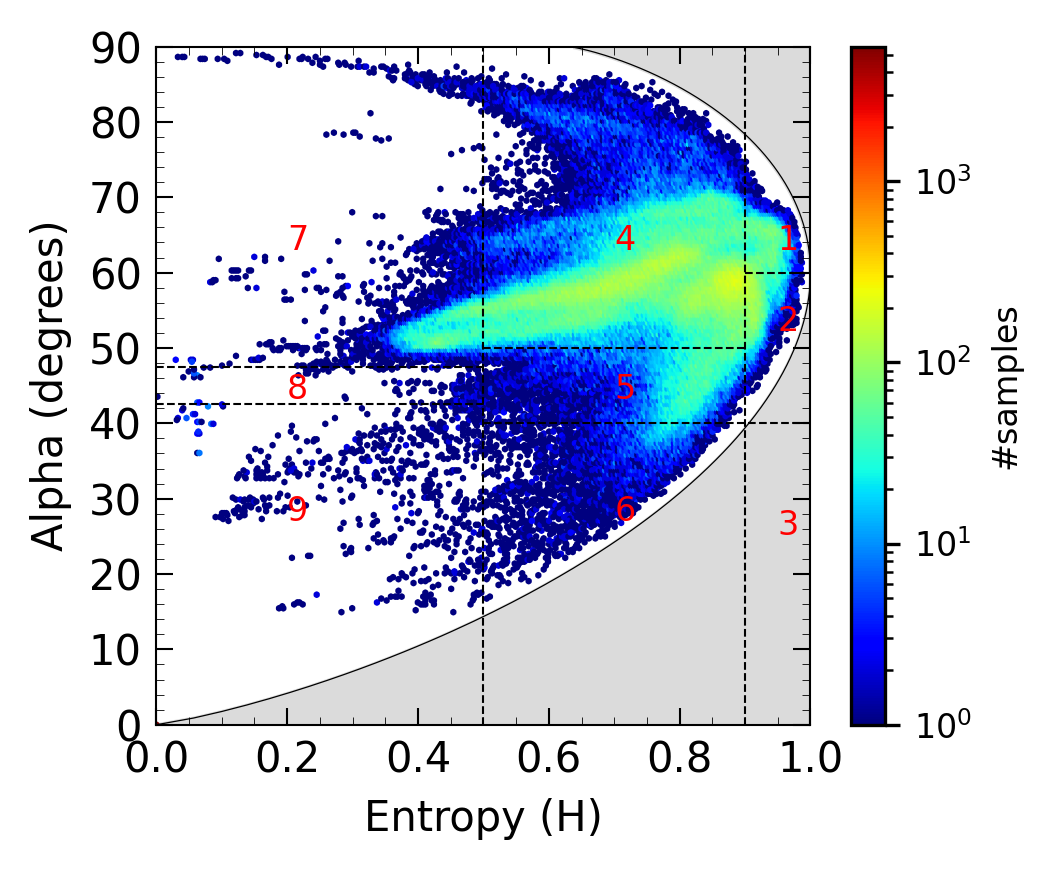

In [7]:
h = pst.utils.read_bin(C3Folder + '/H_fp.tif')
alpha = pst.utils.read_bin(C3Folder + '/alpha_fp.tif')

pst.halpha_plot_fp(h,alpha,cmap='jet',norm='log')